<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Helper functons
In previous notebooks, we have created a series of helper functions to do different tasks, let's download them.

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-15 05:13:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-15 05:13:08 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data
Our goal is to beat original 101 Food101 paper with 10% of training data, let's download it.

The data we are using comes from original Food101 dataset but has been preprocessed with image_data__modification notebook.
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb 

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-01-15 05:13:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   228MB/s    in 6.5s    

2022-01-15 05:13:17 (239 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [9]:
# How many classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 director

In [10]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=IMG_SIZE,
                                                                             label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode='categorical',
                                                             shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of Food101 food classes
Here are the steps we are going to take
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model (we will create our own output layer)
* Compile our model
* Feature extract for 5 full passes

In [11]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [12]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [13]:
# Setup data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.) # This can be applied to models where rescaling is not in built
], name="data_augmentation")

In [14]:
# Setup the base model and freeze it's layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [15]:
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [16]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 90s 317ms/step - loss: 3.5687 - accuracy: 0.2248 - val_loss: 2.7389 - val_accuracy: 0.3872
Epoch 2/5
237/237 [==============================] - 60s 254ms/step - loss: 2.4904 - accuracy: 0.4283 - val_loss: 2.3315 - val_accuracy: 0.4454
Epoch 3/5
237/237 [==============================] - 52s 219ms/step - loss: 2.1342 - accuracy: 0.4887 - val_loss: 2.0926 - val_accuracy: 0.4783
Epoch 4/5
237/237 [==============================] - 50s 210ms/step - loss: 1.9093 - accuracy: 0.5407 - val_loss: 2.0079 - val_accuracy: 0.4971
Epoch 5/5
237/237 [==============================] - 46s 192ms/step - loss: 1.7602 - accuracy: 0.5642 - val_loss: 1.9835 - val_accuracy: 0.4971


In [17]:
model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.7970 - accuracy: 0.5350


[1.7970328330993652, 0.5350494980812073]

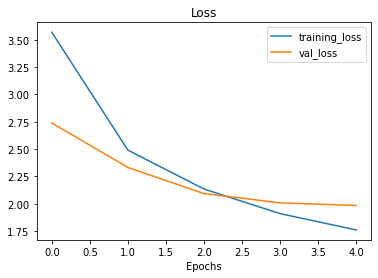

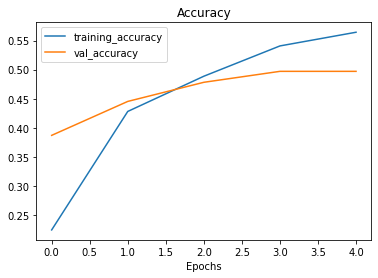

In [18]:
plot_loss_curves(history_all_classes_10_percent)

## Fune-tuning

In [19]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [20]:
# Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [21]:
# What layers are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)



input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [22]:
# Which layers in base_model are trainable
for number, layer in enumerate(model.layers[2].layers):
  print(number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [23]:
 fine_tune_epoch = 10
 history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tune_epoch,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 53s 194ms/step - loss: 1.5202 - accuracy: 0.6160 - val_loss: 1.9404 - val_accuracy: 0.4960
Epoch 6/10
237/237 [==============================] - 43s 180ms/step - loss: 1.3970 - accuracy: 0.6284 - val_loss: 1.9225 - val_accuracy: 0.5056
Epoch 7/10
237/237 [==============================] - 43s 179ms/step - loss: 1.3393 - accuracy: 0.6453 - val_loss: 1.9142 - val_accuracy: 0.5077
Epoch 8/10
237/237 [==============================] - 41s 170ms/step - loss: 1.2442 - accuracy: 0.6738 - val_loss: 1.8764 - val_accuracy: 0.5185
Epoch 9/10
237/237 [==============================] - 40s 166ms/step - loss: 1.2111 - accuracy: 0.6812 - val_loss: 1.8905 - val_accuracy: 0.5162
Epoch 10/10
237/237 [==============================] - 40s 165ms/step - loss: 1.1498 - accuracy: 0.6990 - val_loss: 1.8882 - val_accuracy: 0.5167


In [24]:
model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 1.6721 - accuracy: 0.5608


[1.6720623970031738, 0.560792088508606]

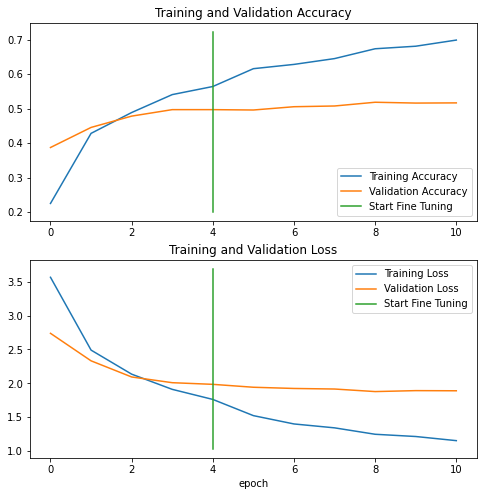

In [25]:
# Compare histories of feature extraction model with fine-tuning
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune)

## Savig and loading our model

To use our model in an external application, we need to save and export it somewhere

In [29]:
 model.save("drive/MyDrive/tensorflow/models/101_food_classes_10_percent_saved_big_dog_model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Evaluating the performance of our big dog model with different classes

Let's make some perdictions and find out for which classes our model is not performing very well.

In [32]:
 import tensorflow as tf
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-01-15 05:42:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c02::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  46.1MB/s    in 1.0s    

2022-01-15 05:42:53 (46.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [34]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [35]:
# Load the model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [36]:
model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]